In [1]:
import numpy as np
import time
import math
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

## Load dataset

In [2]:
X_train, y_train = load_svmlight_file(f="a9a", n_features=123)
X_val, y_val = load_svmlight_file(f="a9a.t", n_features=123)

n_samples, n_features = X_train.shape

## Preprocess the dataset

$$
X =
\left(
\begin{array}{c}
x_1^T;1\\
x_2^T;1\\
\vdots\\
x_n^T;1
\end{array}
\right)
$$

$$
y = 
\left(
\begin{array}{c}
y_1\\
y_2\\
\vdots\\
y_n
\end{array}
\right)
$$

In [3]:
X_train = X_train.toarray()
X_train = np.column_stack((X_train, np.ones((X_train.shape[0], 1))))
X_val = X_val.toarray()
X_val = np.column_stack((X_val, np.ones((X_val.shape[0], 1))))


y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))

## Hyper-parameters

In [4]:
BATCH_SIZE = 64
LEARNING_RATE = 0.002
PENALTY_FACTOR = 0.5
C = 0.5
MAX_EPOCH = 800
FUDGE_FACTOR = 1e-8  # parameter epsilon, guarantees nonzero denominator in Adagrad and Adam
FIRST_DECAY = 0.9  # param mu in Adam
SECOND_DECAY = 0.999  # param nu in Adam

## Hinge loss function

$$ J(w) = C \frac{1}{n}\sum_{i=1}^{n}\max(0, 1-y_i(w^Tx_i + b)) $$

In [5]:
def hinge_loss(w, X, y):
    loss = C * np.maximum(0, 1-y * (X.dot(w))).sum() / X.shape[0]
    return loss

## Gradient of loss function

$$ g_w(x_i) = 
    \begin{cases}
    \begin{aligned}
        &-y_ix_i, & 1 - y_i(w^Tx_i + b) \geqslant 0\\
        &0, & 1 - y_i(w^Tx_i + b) < 0    
    \end{aligned}
    \end{cases}  $$

$$ \frac{\partial J(w)}{\partial w} = \lambda w + C\sum_{i=1}^{n}g_w(x_i) $$

In [6]:
def gradient(w, X, y):
    X_wrong = (1 - y * X.dot(w) < 0)
    y_tmp = y.copy()
    y_tmp[X_wrong] = 0
    
    grad = ((-1) * C * (X.T.dot(y_tmp)) / X.shape[0]) + PENALTY_FACTOR * w
    grad = -grad
    return grad

## Predict function

$$ predict(x_i) =     
\left\{
    \begin{aligned}
        &1, &w^Tx_i + b \geqslant 0\\
        &-1, &w^Tx_i +b < 0,
    \end{aligned}
    \right. $$

In [7]:
def predict(w, X):
    y_pred = X.dot(w)
    y_pred[y_pred >= 0] = 1
    y_pred[y_pred < 0] = -1
    
    return y_pred

## Initialize parameter $w$ with zeros

In [8]:
w = np.zeros((n_features + 1, 1))

## Linear Classification with different methods
 
$$ g_t = \frac{1}{\left|S_k\right|}\sum_{i \in S_k}\nabla_{w}L_i(w) $$

### MSGD

$$ \Delta w_t = -\eta \cdot g_t $$

In [9]:
np.random.seed(int(time.time()))

msgd_losses_val = []
msgd_acc_val = []
for epoch in range(MAX_EPOCH):
    rand = np.random.randint(0, n_samples, size=BATCH_SIZE)
    X_batch = X_train[rand]
    y_batch = y_train[rand]
    grad = gradient(w, X_batch, y_batch)
    w = w + LEARNING_RATE * grad

    loss_val = hinge_loss(w, X_val, y_val)
    msgd_losses_val.append(loss_val)
        
    y_pred = predict(w, X_val)
    acc = (y_pred == y_val).sum() / y_val.shape[0]
    msgd_acc_val.append(acc)

### Adagrad

$$ n_t = n_{t-1} + g_t^2 $$

$$ \Delta w_t = -\frac{\eta}{\sqrt{n_t} + \epsilon}g_t$$

In [10]:
adagrad_losses_val = []
adagrad_acc_val = []

w = np.zeros((n_features + 1, 1))

grad_sqr_sum = 0
for epoch in range(MAX_EPOCH):
    rand = np.random.randint(0, n_samples, size=BATCH_SIZE)
    X_batch = X_train[rand]
    y_batch = y_train[rand]

    grad = gradient(w, X_batch, y_batch)
    grad_sqr_sum += grad**2
    adgrad = grad / (FUDGE_FACTOR + np.sqrt(grad_sqr_sum)) 
    w = w + LEARNING_RATE * adgrad
    
    loss_val = hinge_loss(w, X_val, y_val)
    adagrad_losses_val.append(loss_val)
    
    y_pred = predict(w, X_val)
#     acc = np.count_nonzero(y_pred == y_val)/ y_val.shape[0]
    acc = (y_pred == y_val).sum() / y_val.shape[0]
    adagrad_acc_val.append(acc)
#     print('Epoch: #{}Acc_val: {:.4f}'.format(
#             epoch+1, adagrad_acc_val[-1])
#         )

### Adam

$$ m_t = \mu \cdot m_{t-1} + (1-\mu)\cdot g_t $$

$$ n_t = \nu \cdot n_{t-1} + (1-\nu)\cdot g_t^2 $$

$$ \hat m_t = \frac{m_t}{1-\mu^t} $$

$$ \hat n_t = \frac{n_t}{1-\nu^t} $$

$$ \Delta w_t = -\frac{\hat m_t}{\sqrt{\hat n_t} + \epsilon} \cdot \eta $$

In [11]:
adam_losses_val = []
adam_acc_val = []

w = np.zeros((n_features + 1, 1))

bias_first_est, bias_second_est = 0, 0
for epoch in range(MAX_EPOCH):
    rand = np.random.randint(0, n_samples, size=BATCH_SIZE)
    X_batch = X_train[rand]
    y_batch = y_train[rand]
    grad = gradient(w, X_batch, y_batch)
    
    bias_first_est = FIRST_DECAY * bias_first_est + (1-FIRST_DECAY) * grad
    bias_second_est = SECOND_DECAY * bias_second_est + (1-SECOND_DECAY) * grad**2
    bia_corr_first_est = bias_first_est / (1 - math.pow(FIRST_DECAY, epoch + 1))
    bia_corr_second_est = bias_second_est / (1 - math.pow(SECOND_DECAY, epoch + 1))
    adamgrad = bia_corr_first_est / (np.sqrt(bia_corr_second_est) + FUDGE_FACTOR)
    
    w = w + LEARNING_RATE * adamgrad
    
    loss_val = hinge_loss(w, X_val, y_val)
    adam_losses_val.append(loss_val)
    
    y_pred = predict(w, X_val)
    acc = (y_pred == y_val).sum() / y_val.shape[0]
    adam_acc_val.append(acc)

## Plot

### Loss

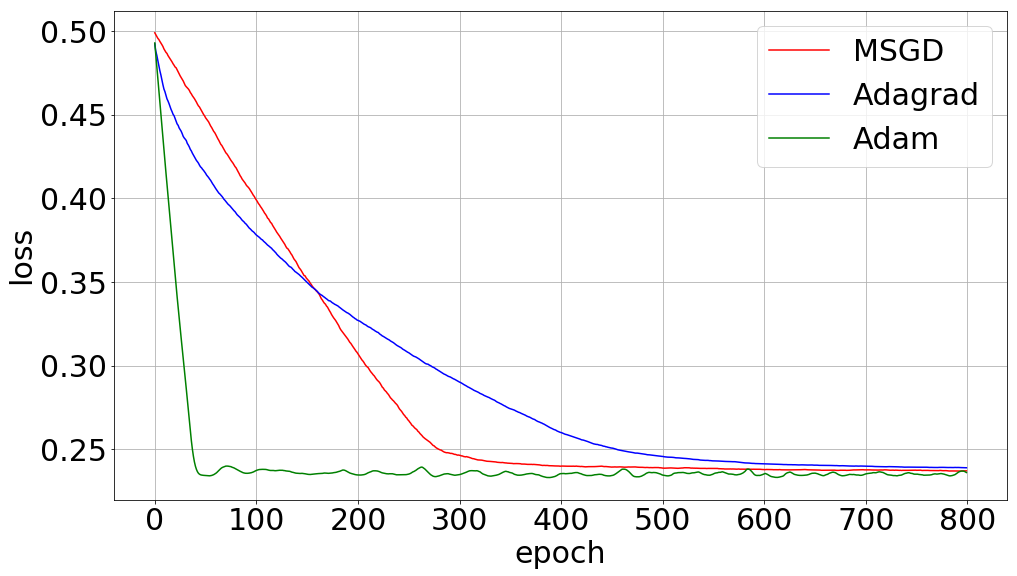

In [12]:
ftsize=30
plt.figure(figsize=(16, 9))
plt.xticks(fontsize=ftsize)
plt.yticks(fontsize=ftsize)
plt.plot(msgd_losses_val, "-", color="r", label="MSGD")
plt.plot(adagrad_losses_val, "-", color="b", label="Adagrad")
plt.plot(adam_losses_val, "-", color="g", label="Adam")
plt.xlabel("epoch", fontsize=ftsize)
plt.ylabel("loss", fontsize=ftsize)
plt.legend(fontsize=ftsize)
plt.grid()
plt.savefig('svm_loss.png')
# plt.title("The graph of logistic loss with different GD algorithms")
plt.show()

### Accuracy

In [13]:
# plt.figure(figsize=(16, 9))
# plt.xticks(fontsize=ftsize)
# plt.yticks(fontsize=ftsize)
# plt.plot(msgd_acc_val, "-", color="r", label="MSGD")
# plt.plot(adagrad_acc_val, "-", color="b", label="Adagrad")
# plt.plot(adam_acc_val, "-", color="g", label="Adam")
# plt.xlabel("epoch", fontsize=ftsize)
# plt.ylabel("accuracy", fontsize=ftsize)
# plt.legend(fontsize=ftsize)
# plt.grid()
# plt.savefig('svm_accuracy.png')
# #plt.title("The graph of prediction accuracy with different algorithms")
# plt.show()